In [1]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from ase.db import connect

from itertools import combinations
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import MinMaxScaler

#from sklearn.preprocessing import StandardScaler

# ToDo

- [ ] Plot RSMD only for 11 initial geoms add this on top or as lines in bgr in plot --> guess there are no peaks, as number of points for every interpolated geom is the same. how does plot look when only using cis and trans geoms?
- [ ] Only include carbon and nitrogen in computing the RSMD
- [ ] Kabsch algorithm
- [ ] Get indexes for alignment from geometries in db: which n is rotating? pcik indexes from non-isomerizing part of geom

# Align geoms

In [2]:
def _rotation(vector,angle,degrees=False):
    if degrees:
        theta = angle*np.pi/180.0;
    else:
        theta = angle
    s = np.sin(theta);
    c = np.cos(theta);
    t = 1 - c; 
    vtmp = vector / np.linalg.norm(vector)
    ele = np.zeros((3,3),dtype=float)
    x,y,z = vtmp

    ele[0][0] = t*x*x + c;
    ele[0][1] = t*x*y + s*z;
    ele[0][2] = t*x*z - s*y;

    ele[1][0] = t*x*y - s*z;
    ele[1][1] = t*y*y + c;
    ele[1][2] = t*y*z + s*x;

    ele[2][0] = t*x*z + s*y;
    ele[2][1] = t*y*z - s*x;
    ele[2][2] = t*z*z + c;

    return ele
    
def rotation_to_axis(geometry, index):

    number = range(len(geometry))
    moved_atom = index
    angle = np.dot(geometry[moved_atom],np.array([1.0,0.0,0.0]))/(np.linalg.norm(geometry[moved_atom]))
    angle = np.arccos(angle)
    
    axis = np.cross(geometry[moved_atom],np.array([1.0,0.0,0.0]))/(np.linalg.norm(geometry[moved_atom]))
    
    rotationmatrix = _rotation(axis,angle)
    rotation_all = np.dot(geometry,rotationmatrix)
    rotation_all_element = rotation_all[moved_atom]
    if rotation_all_element[0] < 0:
        rotation_all = _rotation(axis,180,True)

    return rotation_all


def rotation_to_plane(geometry,index):

    vec_CuC = geometry[index]/(np.linalg.norm(geometry[index]))
    vec_CuCxCuN = np.cross(np.array([1,0,0],dtype=float),vec_CuC)
    angle = np.dot(vec_CuCxCuN,np.array([0.0,0.0,1.0]))/(np.linalg.norm(vec_CuCxCuN))
    angle = np.arccos(angle)
    
    rotationmatrix = _rotation(np.array([1.0,0.0,0.0]),angle)
    rotation_all_C = np.dot(geometry,rotationmatrix)
    rotation_all_C_coordinates = rotation_all_C[index]
    
    if np.abs(rotation_all_C_coordinates[2]) > 1e-10:
        angle = -angle
        rotationamtrix = _rotation(np.array([1.0,0.0,0.0]),angle)
        rotation_all_C = np.dot(geometry,rotationamtrix)

    return rotation_all_C


def align_mol(atXYZ, align_index=[0,1,2]):
    
    atXYZ_1 = atXYZ - atXYZ[align_index[0]]
    atXYZ_2 = rotation_to_axis(atXYZ_1, align_index[1])
    atXYZ_3 = rotation_to_plane(atXYZ_2, align_index[2])
    
    return atXYZ_3


### Read DB and align geometries w.r.t. to each other

In [3]:
def _get_xyz_from_db(datapath, dbname):
   
    ase_db = connect(os.path.join(datapath, dbname))
    n_samples = len(ase_db)
    n_atoms = [row.toatoms().get_global_number_of_atoms() for row in ase_db.select()]
    
    if len(set(n_atoms)) == 1:
        n_atoms = n_atoms[0]
    else:
        raise Exception('''Not all molecules in the database have the same number of atoms. 
            Did you mix databases of different molecules?''')
        
    xyz_matrix = np.array([mol.toatoms().get_positions() for idx, mol in enumerate(ase_db.select())])
    
    return xyz_matrix

In [4]:
def ase_align_mols(ase_db, align_index=[0,1,2]):

    with connect(ase_db) as db:
        for mol in db.select():
            data = mol.data
            xyz = mol.toatoms().get_positions()
            xyz_align = align_mol(atXYZ=xyz, align_index=align_index)
            data['atXYZ_a'] = xyz_align
            db.update(mol.id, data=data)

In [5]:
def calc_rmsd(ase_db, align=True, align_index=[0, 1, 2]):
    bohr2ang = 0.529177
    ref_idx = _get_refgeom_idx(ase_db)

    def get_xyz_from_mol(mol):
        return mol.toatoms().get_positions() if not align else mol.data['atXYZ_a']

    ref_xyz = get_xyz_from_mol(connect(ase_db).get(ref_idx + 1))
    n_atoms, _ = ref_xyz.shape

    rmsd_values = []
    for mol in connect(ase_db).select():
        current_xyz = get_xyz_from_mol(mol)
        diff = current_xyz - ref_xyz
        rmsd = np.sqrt(np.mean(diff**2))
        rmsd_values.append(rmsd * bohr2ang if align else rmsd)

    return rmsd_values
    

### Kabsch Algorithm for RMSD

In [6]:
from scipy.spatial.transform import Rotation as R

def _get_refgeom_idx(ase_db):

    E0 = []
    for idx, mol in enumerate(connect(ase_db).select()):
        #print(mol.data.keys())
        E0.append(mol.data['energy'][0][0])

    min_E0_idx = E0.index(min(E0))
    return min_E0_idx
    
def _kabsch_align(configurations, ref_idx):

    # Step 1: Centering the Coordinates
    center_of_mass = np.mean(configurations, axis=(1, 2), keepdims=True)
    centered_configurations = configurations - center_of_mass

    # Step 2: Aligning the Configurations
    reference_coords = centered_configurations[ref_idx]
    rotation_matrices = R.from_matrix(np.matmul(centered_configurations.transpose(0, 2, 1), reference_coords))
    aligned_configurations = np.matmul(centered_configurations, rotation_matrices.as_matrix())

    return aligned_configurations, reference_coords
    

def calc_kabsch_rmsd(ase_db):

    bohr2ang = 0.529177
    ref_idx = _get_refgeom_idx(ase_db)

    configurations = [mol.toatoms().get_positions() for mol in connect(ase_db).select()]
    xyz_align_all, xyz_ref = _kabsch_align(configurations=configurations, ref_idx=ref_idx)

    rmsd_values = []
    for mol in xyz_align_all:
        diff = mol - xyz_ref
        
        rmsd = np.sqrt(np.mean(diff**2))
        rmsd_values.append(rmsd * bohr2ang)

    return rmsd_values
  

In [7]:
from ase import io

path = os.getcwd()
databases = sorted([n for n in os.listdir(path) if 'Cy' in n and n.endswith('.db')])
molnames = [n.split('_')[1][:-3] for n in databases]

idx = 1

print('For now we just look at the DB of: '+str(molnames[idx]))
db_all_1  = databases[idx]
db_path_1 = io.read(str(molnames[idx])+'_path.xyz', index=':')


For now we just look at the DB of: hc-Cy1


In [8]:
def _label_path(ase_db, ase_path, ase_db_unit='Bohr', ase_path_unit='Angstrom'):

    if ase_db_unit == ase_path_unit:
        conv_path = 1.0
    else:
        if ase_db_unit == 'Bohr' and ase_path_unit == 'Angstrom':
            conv_path = 1/0.52917721067
        else:
            conv_path = 0.52917721067

    path_label = ['no' for _ in range(len(connect(ase_db)))]
    
    for i, mol_path in enumerate(ase_path):
        path_xyz = mol_path.get_positions()*conv_path
        with connect(ase_db) as db:
            for j, mol in enumerate(db.select()):
                curr_xyz = mol.toatoms().get_positions()
                if np.allclose(path_xyz, curr_xyz):
                    path_label[j] = 'yes'

    with connect(ase_db) as db_n:
        for j, mol in enumerate(db_n.select()):
            data = mol.data
            data['path'] = path_label[j]
            db_n.update(mol.id, data=data)
        


In [9]:
_label_path(
    ase_db=databases[1], 
    ase_path=io.read(str(molnames[1])+'_path.xyz', index=':')
)


In [10]:
equal_list = [j for j, mol in enumerate(connect(databases[1]).select()) if mol.data['path'] == 'yes']
equal_list

[18, 119, 220, 320, 421, 522, 623, 724, 825, 924, 1025]

In [11]:
equal_list = [j for j, mol in enumerate(connect(db_all_1).select()) if mol.data['path'] == 'yes']

In [12]:
#equal_list = [j for j, mol in enumerate(path_label) if mol == 'yes']

equal_list, len(equal_list)

([18, 119, 220, 320, 421, 522, 623, 724, 825, 924, 1025], 11)

In [13]:
#align_rmsd = calc_rmsd(ase_db=databases[0], align=True, align_index=[16,14,18]) #C=C bond that isomerizes and one N

d_kabsch_rmsd = {}
for idx, db in enumerate(databases):
    print('Calculating RMSD for '+str(molnames[idx])+' ...')
    d_kabsch_rmsd[molnames[idx]] = calc_kabsch_rmsd(ase_db=db)
    print('... Done \n')


Calculating RMSD for cc-Cy2 ...
... Done 

Calculating RMSD for hc-Cy1 ...
... Done 

Calculating RMSD for hc-Cy2 ...
... Done 

Calculating RMSD for sc-Cy1 ...
... Done 

Calculating RMSD for sc-mCy1 ...
... Done 



In [20]:
cpurple0  = (143/255, 78/255, 113/255)
cpurple1  = (194/255, 144/255, 171/255)
cpurple2  = (220/255, 189/255, 209/255)

cpurple1

(0.7607843137254902, 0.5647058823529412, 0.6705882352941176)

### Make Plots

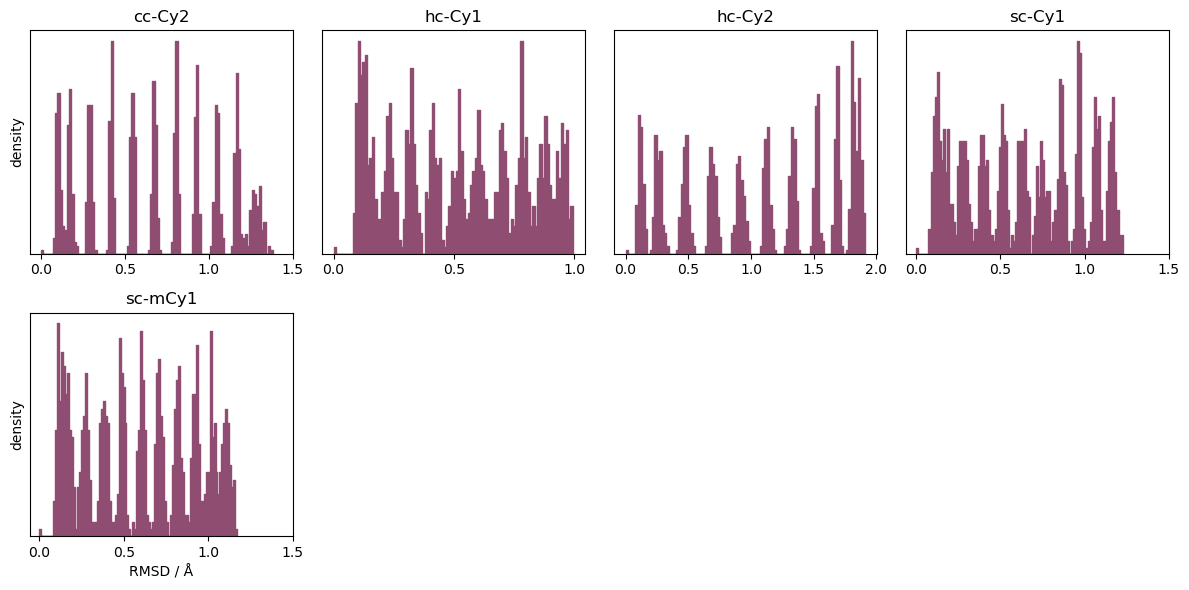

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

c_green  = (110/255, 140/255, 14/255)
c_purple = (143/255, 78/255, 113/255)
c_blue   = (85/255, 118/255, 158/255)

# Calculate the number of rows and columns
num_keys = len(d_kabsch_rmsd)
num_rows = -(-num_keys // 4)  # Equivalent to math.ceil(num_keys / 4)
num_cols = min(4, num_keys)

# Create subplots
if num_rows == 1:
    fig, axes = plt.subplots(1, num_cols, figsize=(3*num_cols, 3*num_rows))
else:
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 3*num_rows))

# Flatten the axes array if there is only one row
axes = axes.flatten() if num_rows > 1 else [axes]

# Iterate through the dictionary and plot histograms
for i, (key, values) in enumerate(d_kabsch_rmsd.items()):
    row_index = i // num_cols
    col_index = i % num_cols
    # histplot
    sns.histplot(pd.DataFrame(values), bins=100, kde=False, 
                 element="step", 
                 stat="density", 
                 ax=axes[i], 
                 facecolor=c_purple, 
                 edgecolor=c_purple,
                 legend=False
                )
    axes[i].set_title(key)

    # Calculate the maximum x-axis value based on data
    max_value = max(values)
    max_value_rounded = ((max_value // 0.5) + 1) * 0.5
    
    # Set x-axis ticks
    axes[i].set_xticks([x * 0.5 for x in range(int(max_value_rounded / 0.5) + 1)])

    axes[i].set_yticks([])

    if row_index == num_rows-1:
        # Set labels and title
        axes[i].set_xlabel('RMSD / Å')
    else:
        axes[i].set_xlabel('')

    if col_index == 0:
        axes[i].set_ylabel('density')
    else:
        axes[i].set_ylabel('')
        
    

# Remove any empty subplots
for i in range(num_keys, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
#plt.show()

plt.savefig('cyanines_RMSDplot.pdf')